In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle
import scipy.stats
import statsmodels.api as sm

import surprise
from surprise.model_selection import train_test_split


import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials


## Load Music Data / Data Collection


In [2]:
artname = pd.read_csv('data/usersha1-artmbid-artname-plays.tsv', sep='\t', header=None, names = ['users', 'artist_id', 'artist_name', 'plays'],
                        usecols = ['users', 'artist_name', 'plays'])
profile = pd.read_csv('data/usersha1-profile.tsv', sep='\t', header=None, names = ['users', 'gender', 'age', 'country', 'sign_up'],
                        usecols = ['users', 'country'])


In [3]:
#Getting all the spotify_data follwing by numbers
filenames = glob.glob('data/spotify_data*.csv')
l = []
for file in filenames: 
    df = pd.read_csv(file)
    l.append(df)
    
spotify_data = pd.concat(l, axis = 0,ignore_index= True)
spotify_data.head()

,trackid,artist_name,track_name,pid
0,spotify:track:2vCtiBvJJZfz773yTfAxPP,Lost Frequencies,What Is Love 2016 - Mike Mago Remix,3000
1,spotify:track:5WOLZP8KrXiupBjG1SSN5U,John Legend,Love Me Now - Dave Audé Remix Radio Edit,3000
2,spotify:track:0oQDQ9QiqsO63EEBAro8Le,July Child,Thinkin of U,3000
3,spotify:track:7MUS0La2IQ85vJ59fQqtoN,Tiësto,I Will Be Here - (Wolfgang Gartner Remix),3000
4,spotify:track:3ciyZYofjiqmMUElM5qgGB,Joe Stone,The Party (This Is How We Do It),3000


In [4]:
#SpotifyClientCredentials that can be used to authenticate requests like
#Using Spotify API to collect more detailed audio features
client_credentials_manager = SpotifyClientCredentials(client_id="ad1a53bb434c4023a44d59b0c5ac533b",client_secret='e25b1aa4183d47b7abb9c0494bb05696')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



In [5]:
trackid = list(set(spotify_data.trackid))
audio_features = []
popularity1 = []

In [6]:
#Since sp.audio_features only works for hundreds of elements, separated trackid into blocks and then applied the function
# for i, group in enumerate(zip_longest(*(iter(trackid),) * 100)):
#     group = list(filter(None, group))
#     audio_features.append(pd.DataFrame(sp.audio_features(tracks=group))) 


In [7]:
features = []
popularity = []
uri = []
batchsize = 50
none_count = 0
none_count2 = 0
for i in range(0,len(trackid),batchsize):
    batch = trackid[i:i+batchsize]
    track_results = sp.tracks(batch)
    features_results = sp.audio_features(tracks = batch)
    for i, t in enumerate(track_results['tracks']):
        if t == None:
            none_count += none_count + 1
        else:
            popularity.append(t['popularity'])
            uri.append(t['uri'])
    for i, t in enumerate(features_results):
        if t == None:
            none_count2 += none_count2 + 1
        else:
            features.append(t)

KeyboardInterrupt: 

In [ ]:
features = pd.DataFrame.from_dict(features)
features = features.drop(['id','analysis_url','type','track_href','type'], axis = 1)
features = features.set_index("uri")
df_pop = pd.DataFrame(
    {'uri': uri,
     'popularity': popularity
    })
df_pop = df_pop.set_index("uri")


In [ ]:
all_features = pd.merge(features,df_pop, left_index=True, right_index=True)
all_features.head()

In [ ]:
pickle.dump(all_features, open( "all_features.p", "wb" ) )
#features = pickle.load( open( "save.p", "rb" ) )b

In [8]:
all_features = pickle.load(open("all_features.p","rb"))
all_features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
uri,,,,,,,,,,,,,,
spotify:track:5t0qHDRcCcrcAFylsEeyG5,0.729000,0.545,296253,0.470,0.015700,4,0.1390,-9.338,0,0.2200,194.082,4,0.5750,0
spotify:track:20tiyvXaJMmnLCnStJY3s5,0.163000,0.565,248760,0.893,0.006580,7,0.8330,-9.374,1,0.0433,131.880,4,0.5540,28
spotify:track:311vr5Ga7G9YN7vbZWXgyb,0.016300,0.768,230960,0.431,0.000248,4,0.0828,-14.467,0,0.1250,171.835,4,0.7910,31
spotify:track:6wrEnhx4sw0USAzbpWNiuH,0.117000,0.562,227000,0.784,0.000047,3,0.0931,-5.783,1,0.0261,104.987,4,0.5190,38
spotify:track:7t7SLzJtQzD8wdJqwYD3XM,0.000034,0.517,235861,0.660,0.252000,5,0.5710,-6.175,0,0.0315,90.007,4,0.0701,54


In [9]:
# Set index as trackid which is the same as index of all_features
spotify_data = spotify_data.set_index('trackid') 

In [10]:
merged = pd.merge(all_features,spotify_data, left_index=True, right_index=True) # Merging Two dataframes based on their indexes to combine all the information.
merged = merged[~merged.index.duplicated(keep='first')] # Dropping duplicated index.

merged['artist_name'] = merged['artist_name'].astype(str).str.lower() # Generalize artist name


In [11]:
merged.info() # 93132 all non-null values. No Missing values.
merged.sort_values(['artist_name','track_name'],inplace=True)
merged.head()

<class 'pandas.core.frame.DataFrame'>
Index: 93132 entries, spotify:track:000VZqvXwT0YNqKk7iG2GS to spotify:track:7zzLt6Z9y7jMvXnEg00n58
Data columns (total 17 columns):
acousticness        93132 non-null float64
danceability        93132 non-null float64
duration_ms         93132 non-null int64
energy              93132 non-null float64
instrumentalness    93132 non-null float64
key                 93132 non-null int64
liveness            93132 non-null float64
loudness            93132 non-null float64
mode                93132 non-null int64
speechiness         93132 non-null float64
tempo               93132 non-null float64
time_signature      93132 non-null int64
valence             93132 non-null float64
popularity          93132 non-null int64
artist_name         93132 non-null object
track_name          93132 non-null object
pid                 93132 non-null int64
dtypes: float64(9), int64(6), object(2)
memory usage: 12.8+ MB


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,artist_name,track_name,pid
spotify:track:7y8aVfDkqt6qirGNivvs0M,0.00255,0.702,243627,0.851,0.000059,10,0.3220,-5.747,0,0.0407,117.004,4,0.870,51,!!!,One Girl / One Boy,3785
spotify:track:32TXsOUIWtTQDkE72Cvafe,0.00232,0.711,351093,0.893,0.196000,9,0.6420,-6.059,1,0.0781,120.751,4,0.629,41,!!!,Pardon My Freedom,2997
spotify:track:0BjOgTLP0kLC88XqMoyrv8,0.06260,0.858,254920,0.717,0.243000,0,0.2160,-8.734,1,0.0995,120.004,4,0.582,39,!!!,Slyd,2871
spotify:track:5zfg3qZOcjS4IFhazNk9PW,0.03640,0.694,313093,0.798,0.024000,2,0.0596,-6.010,1,0.0725,126.073,4,0.456,38,!!!,Yadnus,1633
spotify:track:3MZ0Obyv6AnO1anmGBJydv,0.09200,0.805,48387,0.414,0.719000,1,0.0723,-10.608,0,0.5160,161.707,4,0.527,40,!llmind,Take A Break - Interlude,3162


In [12]:
merged.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,pid
count,93132.000000,93132.000000,9.313200e+04,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000,93132.000000
mean,0.273692,0.576595,2.369183e+05,0.632356,0.103782,5.246371,0.200451,-7.873224,0.664627,0.088594,121.517016,3.918868,0.478873,29.636881,2280.523622
std,0.308156,0.167943,9.934374e+04,0.232925,0.252933,3.579331,0.173221,4.299103,0.472123,0.100402,29.254943,0.387122,0.250161,20.205641,1122.382377
min,0.000000,0.000000,3.056000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018800,0.467000,1.935188e+05,0.478000,0.000000,2.000000,0.096100,-9.495250,0.000000,0.034800,98.879000,4.000000,0.276000,11.000000,1350.000000
50%,0.131000,0.586000,2.246670e+05,0.668000,0.000018,5.000000,0.128000,-6.850000,1.000000,0.047900,120.830500,4.000000,0.467000,31.000000,2445.000000
75%,0.477000,0.699000,2.636000e+05,0.821000,0.008180,8.000000,0.255000,-5.064000,1.000000,0.090900,139.978000,4.000000,0.676000,45.000000,3224.000000
max,0.996000,0.991000,5.279768e+06,1.000000,0.999000,11.000000,1.000000,2.766000,1.000000,0.965000,232.690000,5.000000,1.000000,87.000000,3999.000000


In [13]:
merged.instrumentalness.quantile(np.arange(.9,1,.01))
merged.speechiness.quantile(np.arange(.9,1,.01))
# Lets keep instrumentalness less than .5 as a threshold and speechiness .33
merged_songs = merged[(merged.instrumentalness < .5) & (merged.speechiness < .33)]
merged_songs.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,pid
count,79621.000000,79621.000000,7.962100e+04,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000,79621.000000
mean,0.255561,0.583850,2.340301e+05,0.645841,0.022355,5.252145,0.200776,-7.343930,0.674558,0.075907,121.733803,3.925321,0.494854,30.508434,2292.942063
std,0.290952,0.160236,8.472909e+04,0.220601,0.074474,3.581102,0.172778,3.540087,0.468543,0.066801,28.747000,0.357149,0.244842,20.291976,1115.900905
min,0.000000,0.000000,3.056000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018500,0.476000,1.946620e+05,0.497000,0.000000,2.000000,0.096200,-8.955000,0.000000,0.034400,99.728000,4.000000,0.297000,13.000000,1372.000000
50%,0.122000,0.591000,2.238270e+05,0.677000,0.000007,5.000000,0.129000,-6.587000,1.000000,0.047300,120.917000,4.000000,0.484000,33.000000,2468.000000
75%,0.434000,0.701000,2.597610e+05,0.825000,0.001200,8.000000,0.257000,-4.934000,1.000000,0.085400,139.974000,4.000000,0.688000,46.000000,3217.000000
max,0.995000,0.991000,4.788939e+06,0.999000,0.499000,11.000000,1.000000,2.766000,1.000000,0.329000,232.690000,5.000000,1.000000,87.000000,3999.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2528bcc0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2529c5c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2528bb70>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2529ce10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a252a5278>],
 'means': []}

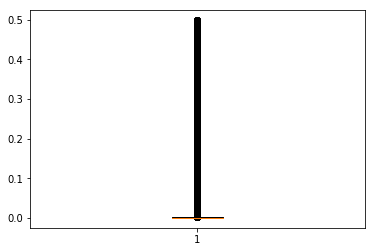

In [14]:
plt.boxplot(merged_songs.instrumentalness)

### Users Data In United States

In [15]:
artname = artname.set_index('users')
profile = profile.set_index('users')

In [16]:
profile_merged = pd.merge(artname,profile, left_index=True, right_index=True)
profile_merged = profile_merged.reset_index()
# Only US profiles.
us_profile = profile_merged[profile_merged.country == "United States"]
us_profile.head()

,users,artist_name,plays,country
195,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456,United States
196,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407,United States
197,00007a47085b9aab8af55f52ec8846ac479ac4fe,cocorosie,386,United States
198,00007a47085b9aab8af55f52ec8846ac479ac4fe,aphex twin,213,United States
199,00007a47085b9aab8af55f52ec8846ac479ac4fe,animal collective,203,United States


In [17]:
# Shows there is no more duplicated rows in the data frame.
has_nan = us_profile.isnull().any(axis=0)
has_nan = [us_profile.columns[i] for i in np.where(has_nan)[0]]
print(has_nan) 

['artist_name']


In [18]:
artists_plays = us_profile.groupby(['artist_name'])['plays'].sum().reset_index()
artists_plays.columns = ['artist_name','total plays']
artists_plays.head()

,artist_name,total plays
0,04)],6
1,mohamed lamine,113
2,the ranting gryphon,4
3,!!!,118625
4,!action pact!,673


In [19]:
users_with_total = us_profile.merge(artists_plays, on='artist_name', how ='left')
users_with_total.head()


,users,artist_name,plays,country,total plays
0,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456,United States,868311.0
1,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407,United States,1750033.0
2,00007a47085b9aab8af55f52ec8846ac479ac4fe,cocorosie,386,United States,382582.0
3,00007a47085b9aab8af55f52ec8846ac479ac4fe,aphex twin,213,United States,1093663.0
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,animal collective,203,United States,1808594.0


In [20]:
artists_plays['total plays'].describe()

count    1.141230e+05
mean     7.470071e+03
std      7.938058e+04
min      1.000000e+00
25%      6.000000e+01
50%      2.210000e+02
75%      9.670000e+02
max      1.070520e+07
Name: total plays, dtype: float64

Difference of min and max is too big for total plays and median of total plays is 221; therefore, I have to set up a reasonable threshold to prevent nosiy data.

In [21]:
artists_plays['total plays'].quantile(np.arange(.9,1,.01))
# Set the threshold to keep about top 3% of the data.
threshold = artists_plays['total plays'].quantile(.97)


In [22]:
top3 = users_with_total[users_with_total['total plays'] >= threshold]
top3 = top3.drop_duplicates(['users','artist_name'])
top3.head()

,users,artist_name,plays,country,total plays
0,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456,United States,868311.0
1,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407,United States,1750033.0
2,00007a47085b9aab8af55f52ec8846ac479ac4fe,cocorosie,386,United States,382582.0
3,00007a47085b9aab8af55f52ec8846ac479ac4fe,aphex twin,213,United States,1093663.0
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,animal collective,203,United States,1808594.0


In [25]:
# Now Pivot the table to transform the data. m items and n users
pivoted = top3.pivot_table(index='artist_name', columns='users', values='plays').fillna(0)
pivoted.head()

users,00007a47085b9aab8af55f52ec8846ac479ac4fe,0001a57568309b287363e72dc682e9a170ba6dc2,00024b5b85c40f990c28644d53257819980bf6bb,0002dd2154072434d26e5409faa591bfb260a01e,00032c7933e0eb05f2258f1147ef81a90f2d4d6c,00041cbfdd019b5431f926133266cc4ba38219bb,000429493d9716b66b02180d208d09b5b89fbe64,000701c3c006b091990162635b36b008c504c6a7,000752c87a61bc4247f5219b4769c347c0062c8a,0008538a0f505f72fdd66af3c4c71aef8d3bdea4,...,fff58a5c95280b7af63f9c552f9159b58ae5efa3,fff694cf332ed701dccbf17f1d9595ba8ad69f22,fff69e7cb53568c732909648527a778c31befec8,fff820efe22db6c868515436de82af39e013b910,fff89b6b5332f0f38996f11c88f908a3924926fe,fff9dc65e7f2763a7e8bce8d99cc1491c2ae4c6f,fffa9294e858a7c863b5ad363c748c2330d9bd45,fffa9d62caff0f038c7a35db70f109b1bba04a1d,fffaf6f9a1a3ad8bd0dff7b48b2eb9eef030fdee,fffe8c7f952d9b960a56ed4dcb40a415d924b224
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(hed) planet earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
*nsync,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
+44,0.0,0.0,394.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...and you will know us by the trail of dead,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### THINGS TO DO 
### How are you going to use count system as rating system.
### FURTHER EDAS.
### HOW ARE YOU GONNA BUILD A LINEAR MODEL SETTING Y=POPUALRITY.
### COMBINE SVD TO SIMILAR FEATURES TO SUMMARIZE FEATURES


In [33]:
trainset, testset = train_test_split(pivoted, test_size=.15)
knn = surprise.KNNWithMeans(k=6,im_options={'name': 'pearson_baseline', 'user_based': True})



AttributeError: 'DataFrame' object has no attribute 'raw_ratings'

## Data Visualization

In [34]:
def heatMap(df):
    """ Taking a dataframe and returns to Heat Map to describe 
        each of features in the df.
    """
    corr = df.corr()
    # Return Upper Triangular Correlation Matrix, since corr matrix is symmetric.
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set Figures
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate Heat Map based on Correlation
    sns.heatmap(corr, mask=mask, cmap=colormap, annot=True, fmt=".2f")
    
    # Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    # Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    # Show plot
    plt.show()

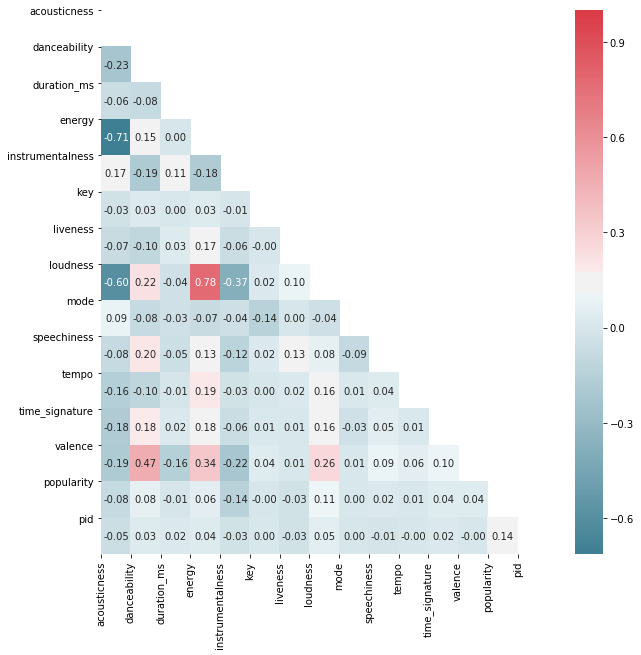

In [35]:
heatMap(merged)

As we can see from the heat map, energy and loudness are negativley correlated with acousticness, but strongly positively correlated to each other.
There is no significant factor that affects popularity; however, there is a slightly negative correlation bewteen instrumentalness and popularity. It might be the fact that classical musics are instrumental and are not frequently on Billboard Top 100.

In [ ]:
#plt.hist(x=artists_merged['total plays'], normed=True, bins=100, histtype='stepfilled')
artists_merged['total plays'].describe()

There was a huge difference between minimum plays and maximum plays. Hence, I would like to exclude some data points to prevent the noise.

In [ ]:
#total = pd.merge(profile_merged,merged, on='artist_name', how='left')

How to connect KNN two matrix. 
1. profile and artist_name --> Will recommend artist based on the number of plays. Collarborative Filtering
2. songs and features --> will recommend songs. Content Based Filters.

Get average of each features for unique artists and then apply knn to get similar artist based on features?
How to connect User-based and item-based.

In [50]:
result = sm.OLS(merged_songs.tempo, merged_songs.popularity).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempo   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                 1.526e+05
Date:                Fri, 28 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:14:24   Log-Likelihood:            -4.5486e+05
No. Observations:               79621   AIC:                         9.097e+05
Df Residuals:                   79620   BIC:                         9.097e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
popularity     2.7672      0.007    390.585      0.000       2.753       2.781
==============================================================================
Omnibus:                     3265.985   Durbin-Watson:                   1.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1410.485
Skew:                           0.045   Prob(JB):                    5.21e-307
Kurtosis:                       2.354   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TypeError: len() of unsized object

In [47]:
r_value

0.0019201567821666736